In [75]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [76]:
!mkdir dataset
!curl -L -o dataset/micro_gas_turbine_electrical_energy_prediction.zip https://archive.ics.uci.edu/static/public/994/micro+gas+turbine+electrical+energy+prediction.zip

A subdirectory or file dataset already exists.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 16309    0 16309    0     0  18675      0 --:--:-- --:--:-- --:--:-- 18681
100 85941    0 85941    0     0  44471      0 --:--:--  0:00:01 --:--:-- 44482
100  163k    0  163k    0     0  59709      0 --:--:--  0:00:02 --:--:-- 59715
100  255k    0  255k    0     0  68348      0 --:--:--  0:00:03 --:--:-- 68353
100  347k    0  347k    0     0  74072      0 --:--:--  0:00:04 --:--:-- 74085
100  467k    0  467k    0     0  81780      0 --:--:--  0:00:05 --:--:-- 92829
100  627k    0  627k    0     0  93788      0 --:--:--  0:00:06 --:--:--  110k
100  843k    0  843k    0     0   108k      0 --:--:--  0:00:07 --:--:--  135k
100  887k    0  887k    0     0   110k      0 --:--:--  0:00:08 --:--:--  151k


In [77]:
import pandas as pd
import math
import glob
import matplotlib.pyplot as plt
import zipfile
from sklearn.preprocessing import StandardScaler

In [78]:
zipfile.ZipFile('dataset/micro_gas_turbine_electrical_energy_prediction.zip').extractall('dataset/')
zipfile.ZipFile('dataset/test.zip').extractall('dataset/')
zipfile.ZipFile('dataset/train.zip').extractall('dataset/')

In [79]:
path_test = glob.glob('dataset/test/*.csv')
path_train = glob.glob('dataset/train/*.csv')

In [80]:
# Juntar todos os arquivos de treino em um único DataFrame
df_train = pd.concat([pd.read_csv(f) for f in path_train], ignore_index=True)
df_test = pd.concat([pd.read_csv(f) for f in path_test], ignore_index=True) 
len(df_train), len(df_test)

(52940, 18285)

In [81]:
df_train.head()

,time,input_voltage,el_power
0,810.07028,10.0,1228.791720
1,811.06938,10.0,1223.041745
2,812.06848,10.0,1244.960866
3,813.06758,10.0,1229.259058
4,814.06668,10.0,1248.117024


In [82]:
# Verificar o tempo de cada medição
df_train['time'].min(), df_train['time'].max(), (df_train['time'].max() - df_train['time'].min()) / 3600

(np.float64(810.0), np.float64(12636.84), np.float64(3.2852333333333332))

In [83]:
df_test['time'].min(), df_test['time'].max(), (df_test['time'].max() - df_test['time'].min()) / 3600

(np.float64(758.425813187233),
 np.float64(10545.5323989833),
 np.float64(2.7186407182766854))

In [84]:
df_test.head()

,time,input_voltage,el_power
0,880.3,3.0,1193.140713
1,881.3,3.0,1107.066421
2,882.3,3.0,1180.406767
3,883.3,3.0,1095.551498
4,884.3,3.0,1177.073719


In [85]:
colunas = df_train.columns

In [86]:
column_used = colunas[-1]  # Target column
column_used

'el_power'

# Funções utilizadas e base para a análise temporária

In [87]:
x_train = df_train[colunas[0]]
y_train = df_train[column_used]

x_test = df_test[colunas[0]]
y_test = df_test[column_used]

In [88]:
def calculo_b1_b0(column_x,column_y):
    x_mean = column_x.sum() / len(column_x)
    y_mean = column_y.sum() / len(column_y)
    
    numerador = 0
    denominador = 0
    
    for i in range(len(column_x)):
        numerador += (column_x[i] - x_mean) * (column_y[i] - y_mean)
        denominador += (column_x[i] - x_mean) ** 2
    
    b1 = numerador / denominador
    
    b0 = y_mean - (x_mean*b1)
    
    return b1,b0

b1,b0 = calculo_b1_b0(x_train,y_train)
b1,b0

(np.float64(0.056726897947851566), np.float64(1525.2797606834586))

In [89]:
def calculo_pred(b1,b0,x):
    return (b1 * x) + b0

In [90]:
def pred_test(column_x_test):
    column_y_pred = []
    
    for x in column_x_test:
        column_y_pred.append(calculo_pred(b1,b0,x))
    
    return column_y_pred
column_y_pred = pred_test(x_test)

In [91]:
def rmse(column_y_real,column_y_pred):
    n = len(column_y_real)
    numerador = 0.0
    
    for i in range(n):
        numerador += (column_y_real[i] - column_y_pred[i]) ** 2
    
    result = numerador / n
    
    return math.sqrt(result)

rmse(y_test,column_y_pred)

765.7460874262545

In [92]:
def mse(column_y_real,column_y_pred):
    n = len(column_y_real)
    numerador = 0.0
    
    for i in range(n):
        numerador += (column_y_real[i] - column_y_pred[i]) ** 2
    
    result = numerador / n
    
    return result

mse(y_test,column_y_pred)

np.float64(586367.0704086169)

# Validação real

In [93]:
best_column = ''
best_rmse = float('inf')
results = []

for column in colunas:
    if column == column_used:
        continue

    if df_train[column].dtype in ['float64', 'int64']:
        
        x_train = df_train[column]
        x_test = df_test[column]

        y_train = df_train[column_used]
        y_test = df_test[column_used]
        
        b1,b0 = calculo_b1_b0(x_train,y_train)
        column_y_pred = pred_test(x_test)
        
        rmse_value = rmse(y_test,column_y_pred)
        mse_value = mse(y_test,column_y_pred)
        
        if rmse_value < best_rmse:
            best_rmse = rmse_value
            best_column = column
        
        results.append((column, b1, b0, rmse_value, mse_value))
    else:
        print(f"Pulando coluna categórica: {column}")

print(f"Melhor coluna: {best_column} com RMSE: {best_rmse}")

Melhor coluna: input_voltage com RMSE: 382.6748888289727


In [94]:
df = pd.DataFrame(results, columns=['Column', 'b1', 'b0', 'RMSE', 'MSE']).sort_values(by='RMSE').reset_index(drop=True)
df

,Column,b1,b0,RMSE,MSE
0,input_voltage,250.184413,465.917254,382.674889,146440.070540
1,time,0.056727,1525.279761,765.746087,586367.070409


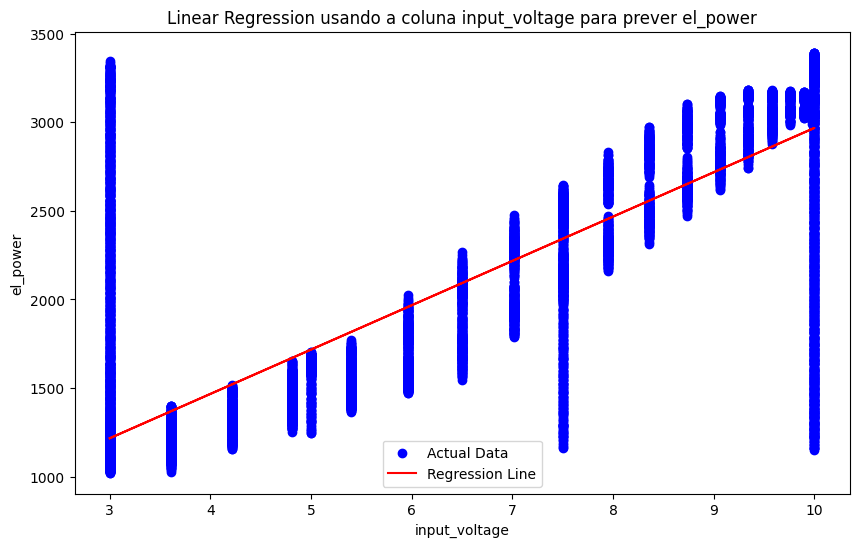

In [95]:
plt.figure(figsize=(10,6))
plt.scatter(x_test, y_test, color='blue', label='Actual Data')
plt.plot(x_test, column_y_pred, color='red', label='Regression Line')
plt.xlabel(best_column)
plt.ylabel(column_used)
plt.title(f'Linear Regression usando a coluna {best_column} para prever {column_used}')
plt.legend()

# Regressão multiplas

## Formulas

### Regressão Linear multipla

Função geral da regressão linear múltipla:
Y = β0 + β1X1 + β2X2 + ... + βnXn + ε

#### Descrição dos termos:
- Y: Variável dependente (o que estamos tentando prever)
- X1, X2, ..., Xn: Variáveis independentes (os preditores)
- β0: Essa variavel é o intercepto, ou seja, o valor de Y quando todas as variáveis independentes são iguais a zero.
- β1, β2, ..., βn: Coeficientes de regressão que representam a mudança esperada em Y para uma unidade de mudança em cada variável independente, mantendo todas as outras constantes.

Função de custo:
J(β) = (1/2m) * Σ (Yi - (β0 + β1X1i + β2X2i + ... + βnXni))^2

Gradiente descendente:
βj := βj - α * (∂J(β)/∂βj)



In [ ]:
import numpy as np

def funcao_custo(X, y, coeficientes):
    m = len(y)
    y_pred = coeficientes[0] + np.dot(X, coeficientes[1:])
    erro = y_pred - y
    return np.sum(erro ** 2) / (2 * m)


def calcular_gradientes(X, y, coeficientes):
    m = len(y)
    y_pred = coeficientes[0] + np.dot(X, coeficientes[1:])
    erro = y_pred - y
    grad_intercept = np.sum(erro) / m
    grad_features = np.dot(X.T, erro) / m
    return np.concatenate([[grad_intercept], grad_features])


def fazer_predicoes(X, coeficientes):
    predicoes = []
    n_features = X.shape[1]
    
    for i in range(len(X)):
        h_beta = coeficientes[0]  # intercepto
        for j in range(n_features):
            h_beta += X[i][j] * coeficientes[j+1]
        predicoes.append(h_beta)
    
    return predicoes

def gradiente_descendente_melhorado(X, y, coeficientes_inicial, alpha, epochs, tolerancia=1e-6):
    """
    Versão com algumas melhorias opcionais
    """
    coeficientes = coeficientes_inicial.copy()
    custo_historico = []
    
    for epoch in range(epochs):
        gradientes = calcular_gradientes(X, y, coeficientes)
        
        # Atualização dos coeficientes
        for j in range(len(coeficientes)):
            coeficientes[j] = coeficientes[j] - alpha * gradientes[j]
    
        custo = funcao_custo(X, y, coeficientes)
        custo_historico.append(custo)
        
        # Verificar convergência
        if epoch > 0 and abs(custo_historico[-2] - custo) < tolerancia:
            print(f"Convergiu na época {epoch}")
            break
    
        if epoch % 100 == 0 or epoch < 10:
            print(f"Epoch {epoch:4d}: Custo = {custo:.6f}")
    
    print(f"Coeficientes finais: {coeficientes}")
    return coeficientes, custo_historico
    

In [ ]:
def funcao_custo(X, y, coeficientes):
    """
    Calcula a função de custo usando NumPy mas mantendo a fórmula explícita
    Fórmula: J(β) = (1/2m) * Σ(hβ(x^(i)) - y^(i))²
    """
    m = len(y)
    
    # Calcular predições: β₀ + X @ β[1:]
    predicoes = coeficientes[0] + np.dot(X, coeficientes[1:])
    
    # Calcular erros
    erros = predicoes - y
    
    # Somar erros quadrados e aplicar fórmula da função de custo
    soma_erros_quadrados = np.sum(erros ** 2)
    custo_final = soma_erros_quadrados / (2 * m)
    
    return custo_final


def calcular_gradientes(X, y, coeficientes):
    """
    ∂J/∂β₀ = (1/m) * Σ(hβ(x^(i)) - y^(i))
    ∂J/∂βⱼ = (1/m) * Σ(hβ(x^(i)) - y^(i)) * xⱼ^(i)
    """
    m = len(y)
    
    # Calcular predições: β₀ + X @ β[1:]
    predicoes = coeficientes[0] + np.dot(X, coeficientes[1:])
    
    erros = predicoes - y
    
    # Gradiente do intercepto: (1/m) * Σ(erro)
    grad_intercepto = np.sum(erros) / m
    
    # Gradientes das features: (1/m) * X^T @ erros
    # O símbolo @ representa a multiplicação de matrizes
    grad_features = np.dot(X.T, erros) / m
    
    # Combinar gradientes
    gradientes = np.concatenate([[grad_intercepto], grad_features])
    
    return gradientes


def fazer_predicoes(X, coeficientes):
    """
    Faz predições usando NumPy mas mantendo a fórmula explícita
    hβ(x) = β₀ + β₁*x₁ + β₂*x₂ + ... + βₙ*xₙ
    """
    # Aplicar fórmula: β₀ + X @ β[1:]
    predicoes = coeficientes[0] + np.dot(X, coeficientes[1:])
    
    return predicoes.tolist()  # Converter para lista para compatibilidade


def gradiente_descendente(X, y, coeficientes_inicial, alpha, epochs, tolerancia=1e-6):
    """
    Implementação do gradiente descendente com NumPy
    βⱼ := βⱼ - α * ∇J(β)
    """
    # Copiar coeficientes iniciais
    coeficientes = np.array(coeficientes_inicial.copy())
    custo_historico = []
    
    for epoch in range(epochs):
        # Calcular gradientes
        gradientes = calcular_gradientes(X, y, coeficientes)
        
        # Atualizar coeficientes: β := β - α * ∇J(β)
        coeficientes = coeficientes - alpha * gradientes
        
        # Calcular custo atual
        custo_atual = funcao_custo(X, y, coeficientes)
        custo_historico.append(custo_atual)
        
        # Verificar convergência
        if epoch > 0:
            mudanca_custo = abs(custo_historico[-2] - custo_atual)
            
            if mudanca_custo < tolerancia:
                break
        
        # Mostrar progresso
        if epoch % 100 == 0 or epoch < 10:
            print(f"Epoch {epoch:4d}: Custo = {custo_atual:.6f}")
    
    return coeficientes.tolist(), custo_historico


def gradiente_descendente_melhorado(X, y, coeficientes_inicial, alpha, epochs, tolerancia=1e-6):
    """
    Versão melhorada com validação de parâmetros
    """
    # Validar entrada
    X = np.array(X)
    y = np.array(y)
    coeficientes = np.array(coeficientes_inicial.copy())
    
    custo_historico = []
    melhor_custo = float('inf')
    melhor_coeficientes = coeficientes.copy()
    
    for epoch in range(epochs):
        # Calcular gradientes usando as fórmulas explícitas
        gradientes = calcular_gradientes(X, y, coeficientes)
        
        # Atualização com a fórmula do gradiente descendente
        coeficientes_novos = coeficientes - alpha * gradientes
        
        # Calcular custo com a nova configuração
        custo_atual = funcao_custo(X, y, coeficientes_novos)
        custo_historico.append(custo_atual)
        
        # Guardar melhor configuração
        if custo_atual < melhor_custo:
            melhor_custo = custo_atual
            melhor_coeficientes = coeficientes_novos.copy()
        
        # Atualizar coeficientes
        coeficientes = coeficientes_novos
        
        # Verificar convergência
        if epoch > 0:
            mudanca_custo = abs(custo_historico[-2] - custo_atual)
            
            if mudanca_custo < tolerancia:
                break
        
        if epoch % 100 == 0 or epoch < 10:
            print(f"Epoch {epoch:4d}: Custo = {custo_atual:.6f}")
            
    
    return melhor_coeficientes.tolist(), custo_historico


def calcular_metricas(y_real, y_pred):
    """
    Calcula métricas de avaliação usando NumPy
    """
    y_real = np.array(y_real)
    y_pred = np.array(y_pred)
    
    # MSE: (1/n) * Σ(y_real - y_pred)²
    mse = np.mean((y_real - y_pred) ** 2)
    
    # RMSE: √MSE
    rmse = np.sqrt(mse)
    
    # MAE: (1/n) * Σ|y_real - y_pred|
    mae = np.mean(np.abs(y_real - y_pred))
    
    # R²: 1 - (SS_res / SS_tot)
    ss_res = np.sum((y_real - y_pred) ** 2)
    ss_tot = np.sum((y_real - np.mean(y_real)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return {
        'MSE': mse,
        'RMSE': rmse, 
        'MAE': mae,
        'R²': r2
    }

In [142]:
# Preparação sem adicionar coluna de 1's
scaler = StandardScaler()
X_train = df_train[['input_voltage', 'time']].to_numpy() 
y_train = df_train['el_power'].to_numpy()
X_test = df_test[['input_voltage', 'time']].to_numpy() 
y_test = df_test['el_power'].to_numpy()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
coef_iniciais = np.zeros(3)  # [β₀, β₁, β₂]

coeficientes, historico = gradiente_descendente(X_train_scaled, y_train, coef_iniciais, alpha=0.001, epochs=10000)
y_pred = fazer_predicoes(X_test_scaled, coeficientes)
metricas = calcular_metricas(y_test, y_pred)
metricas

Epoch    0: Custo = 1956526.801121
Epoch    1: Custo = 1952703.568724
Epoch    2: Custo = 1948888.071492
Epoch    3: Custo = 1945080.293694
Epoch    4: Custo = 1941280.219635
Epoch    5: Custo = 1937487.833649
Epoch    6: Custo = 1933703.120103
Epoch    7: Custo = 1929926.063397
Epoch    8: Custo = 1926156.647962
Epoch    9: Custo = 1922394.858260
Epoch  100: Custo = 1610070.501068
Epoch  200: Custo = 1327074.496930
Epoch  300: Custo = 1095867.607504
Epoch  400: Custo = 906934.204570
Epoch  500: Custo = 752514.322102
Epoch  600: Custo = 626278.307424
Epoch  700: Custo = 523062.047464
Epoch  800: Custo = 438651.434807
Epoch  900: Custo = 369606.871023
Epoch 1000: Custo = 313120.333825
Epoch 1100: Custo = 266898.936964
Epoch 1200: Custo = 229070.049466
Epoch 1300: Custo = 198103.964122
Epoch 1400: Custo = 172750.854729
Epoch 1500: Custo = 151989.370263
Epoch 1600: Custo = 134984.708664
Epoch 1700: Custo = 121054.414697
Epoch 1800: Custo = 109640.472945
Epoch 1900: Custo = 100286.532515
E

{'MSE': np.float64(143914.9114843253),
 'RMSE': np.float64(379.36118869004684),
 'MAE': np.float64(217.8483708916848),
 'R²': np.float64(0.7799313758032764)}

In [143]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaled, y_train)
pred_sklearn = model.predict(X_test_scaled)
model.coef_, model.intercept_

(array([631.17247847,  30.98018916]), np.float64(1843.3159492020916))

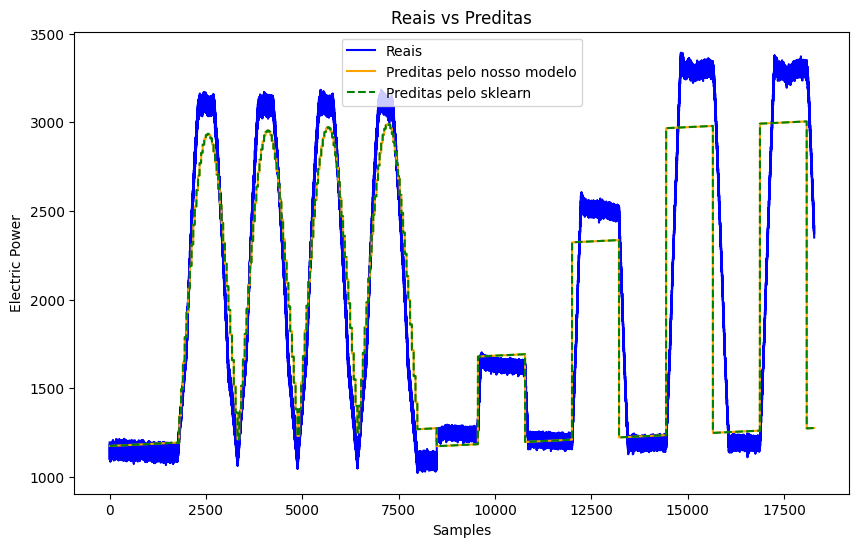

In [144]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(y_test, label='Reais', color='blue')
ax.plot(y_pred, label='Preditas pelo nosso modelo', color='orange')
ax.plot(pred_sklearn, label='Preditas pelo sklearn', color='green', linestyle='--')
ax.set_xlabel('Samples')
ax.set_ylabel('Electric Power')
ax.set_title('Reais vs Preditas')
ax.legend()